<a href="https://colab.research.google.com/github/AilingLiu/From-Business-Insights-to-Action/blob/master/Customer_Segmentation_by_RFM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
import seaborn as sns

Check [here](https://towardsdatascience.com/data-driven-growth-with-python-part-2-customer-segmentation-5c019d150444) to understand what is RFM. 

- R: recency, the last time that customer being active till the point of analysis
- F: frequency, how frequent the customer is using the product/being online
- M: monetary, how much revenue company gained from the customer

RFM is one of the traditional measurements of customer segmentation. Customer segmentation gives your company direction where to put retention efforts.

In the article referred above, the author calculate the frequency and revenue from customer alive till analysis point. As far as I am concerned, this will reduce the RFM score from new clients, who only starts to use the product recently, so high revenue and high frequency are unlikely. 

Moreoever, the author uses KMeans to categorize each RFM metric. Here, I will be only using percentile of where the customer's RFM sits in the sample as label.

After creating the RFM score, I will use KMeans and graph to identify customer groups.

# Get the data

In [4]:
url = 'https://github.com/AilingLiu/Growth_Analysis/blob/master/Data/online_retail.csv?raw=true'

data = pd.read_csv(url, sep=',', parse_dates=['InvoiceDate'], encoding='latin-1')
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null datetime64[ns]
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [13]:
data.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


# Clean up data

In [0]:
# clean up the negative quantity and unit price
df = data.loc[(data['Quantity'] >=0)&(data['UnitPrice']>=0), :]

# clean up rows where customerid is unknown
mask =df['CustomerID'].isnull() 
df = df.loc[~mask, :]

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 397924 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      397924 non-null object
StockCode      397924 non-null object
Description    397924 non-null object
Quantity       397924 non-null int64
InvoiceDate    397924 non-null datetime64[ns]
UnitPrice      397924 non-null float64
CustomerID     397924 non-null float64
Country        397924 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.3+ MB


In [83]:
df['CustomerID'].nunique()

4339

We have 4339 unique customers after cleaning.

In [21]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,397924.000000,397924.000000,397924.000000
mean,13.021823,3.116174,15294.315171
std,180.420210,22.096788,1713.169877
min,1.000000,0.000000,12346.000000
25%,2.000000,1.250000,13969.000000
50%,6.000000,1.950000,15159.000000
75%,12.000000,3.750000,16795.000000
max,80995.000000,8142.750000,18287.000000


# create recency

Recency: Data collection date - customer last invoice date

In [0]:
m = df['InvoiceDate'].max().normalize()
diff = lambda sbf: (m-sbf.max().normalize()).days

df['Recency'] = df.groupby('CustomerID')['InvoiceDate'].transform(diff)

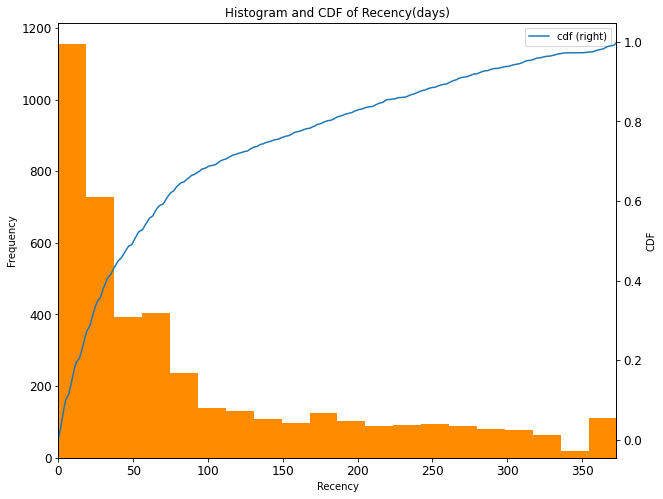

In [94]:
temp_ = df.groupby(['CustomerID', 'Recency']).size().reset_index()
temp_['cdf'] = temp_['Recency'].rank(method = 'average', pct = True)

ax = temp_['Recency'].plot.hist(bins=20, 
                        figsize=(10, 8),
                        color='DarkOrange',
                        title='Histogram and CDF of Recency(days)')

ax1=temp_.sort_values('Recency').plot(x='Recency', 
                                  y='cdf',
                                  ax=ax,
                                  secondary_y=True)
ax1.set_ylabel('CDF')
plt.xlabel('Recency(days)')
plt.show()

In [95]:
temp_['Recency'].describe()

count    4339.000000
mean       92.041484
std       100.007757
min         0.000000
25%        17.000000
50%        50.000000
75%       141.500000
max       373.000000
Name: Recency, dtype: float64

In [100]:
temp_['Recency'].quantile([0, .25, .5, .75, 1]).values

array([  0. ,  17. ,  50. , 141.5, 373. ])

50% of the customers have recency within the last 50 days, among which 25% of them have recency within 17 days. About 25% of customers have more than 5 months recency.

A good way to categorize the Recency is to use percentile. Here we can cut it into four categories [.25, .5, .75, 1], based on percentile.


In [0]:
bins = temp_['Recency'].quantile([0, .25, .5, .75, 1]).values

#pd.cut(df['Recency'],bins=bins, labels=[1,2,3,4])

The recency has been categorized in 1 to 4 classes:

1: [0, 50]: customer placed order within 50 days
2: (50, 131]: customer placed order within 50 to 131 days (
3: (131, 246]
4: (246, 373]

# create frequency

# create revenue

# K Means clustering